In [4]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import itertools
from functools import partial
import pdb
import pandas as pd

from analysis.hit_rate_analysis import (
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from utils.utils import seed_everything
from models.rnn import multi_channel_mse, er_rmse, fold_rmse, p_value_rmse
from matplotlib.patches import Rectangle
from analysis.evaluation import cross_validate_and_benchmark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile =f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest, 
    other_protein=other_protein
)

/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


# Joint Model

/home/yitongt/ml_phage/src/analysis/evaluation.py:59: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred_rescaled for result in results)
/home/yitongt/ml_phage/src/analysis/evaluation.py:60: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for result in results)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(-7.122755271379493, 5.768546213644784, 0.41889799885009615, 11.095790609299698)


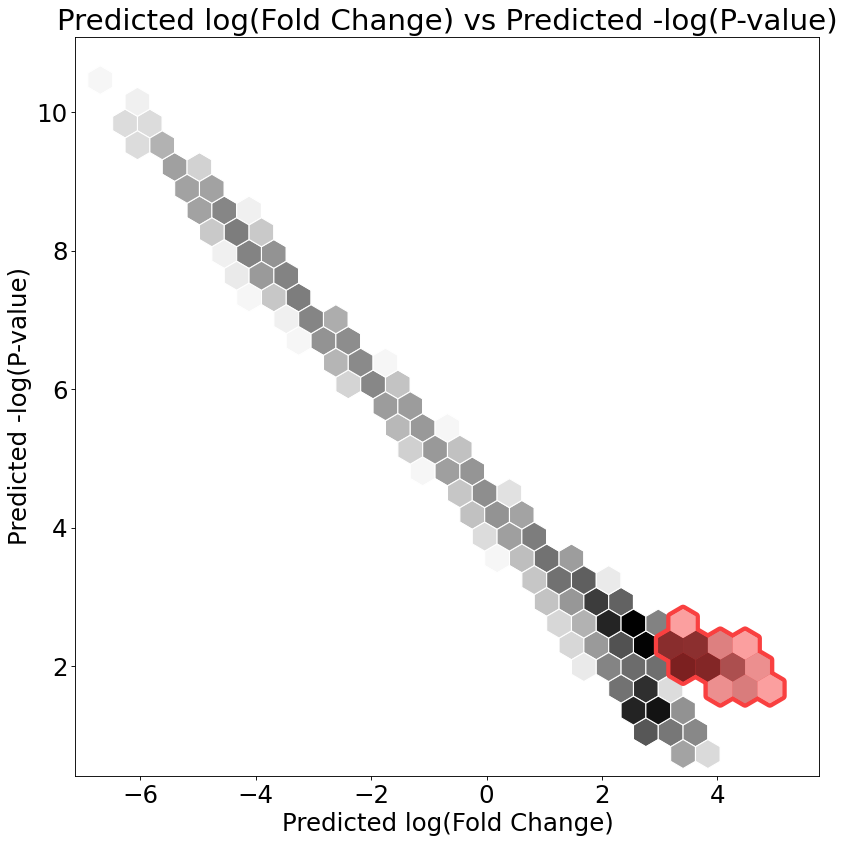

(-7.122755271379493, 5.768546213644784, 0.41889799885009615, 11.095790609299698)


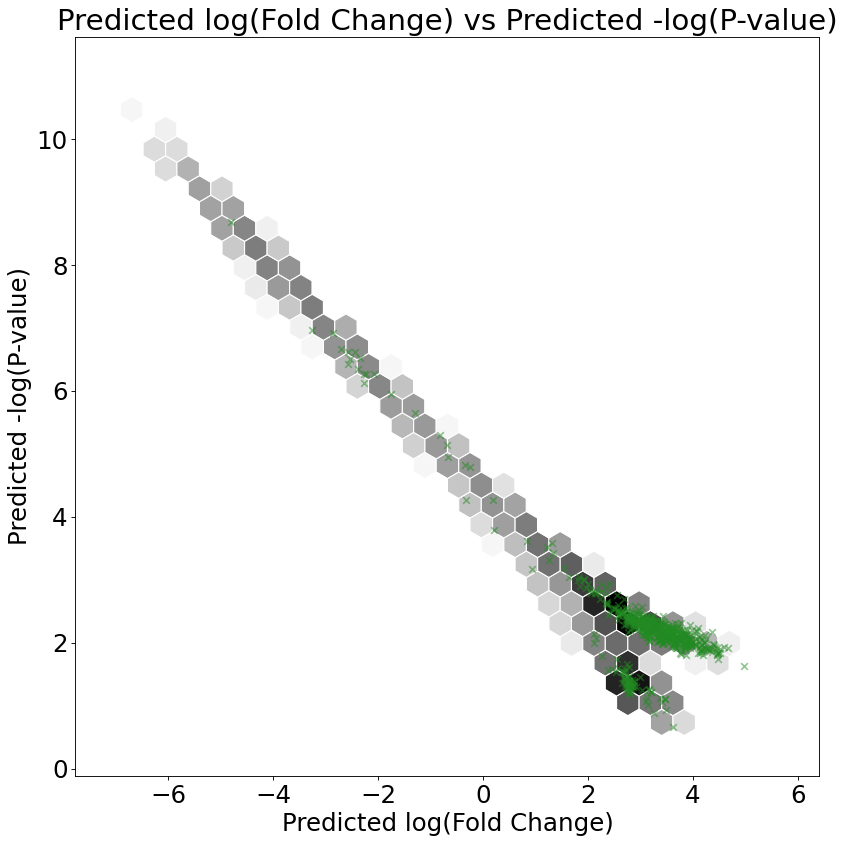

In [10]:
bilstm_ordering, y_pred = cross_validate_and_benchmark( 
    X,
    y_raw,
    peptides,
    model_save_name="trained_model/final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "trained_model/final_models/12ca5_model.h5",
    loss=multi_channel_mse,
    motif_dectection_func=seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif,
    load_trained_model=True,
    calculate_proxy_uncertainty=False,
)

In [11]:
idx = "2"
_, result = experiment.Experiment().run_adhoc_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=128
    ),
    test_train_split=0.1,
    optimizer=partial(keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5),
    load_trained_model=True,
    model_save_name="trained_model/final_models/mdm2_model.h5" + idx
    if protein_of_interest == "MDM2"
    else "trained_model/final_models/12ca5_model.h5" + idx,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)

mdm2_model = result.trained_model


In [12]:
embedding = umap.embedding_classification(mdm2_model, X, layer_depth=16)

# Save UMAP decomp
result_df = pd.DataFrame(embedding, columns=["UMAP PC1", "UMAP PC2"])
result_df["Peptide"] = peptides
result_df["True PVal"] = y_raw[:, 0]
result_df["True FC"] = y_raw[:, 1]
result_df["True ER"] = y_raw[:, 2]

result_df["Pred PVal"] = y_pred[:, 0]
result_df["Pred FC"] = y_pred[:, 1]
result_df["Pred ER"] = y_pred[:, 2]
result_df.to_csv(f"{protein_of_interest}_umap_decomposition.csv")

The size we are going with for MDM2 hotspot 27030
The size we are going with for 12ca5 hotspot 5575


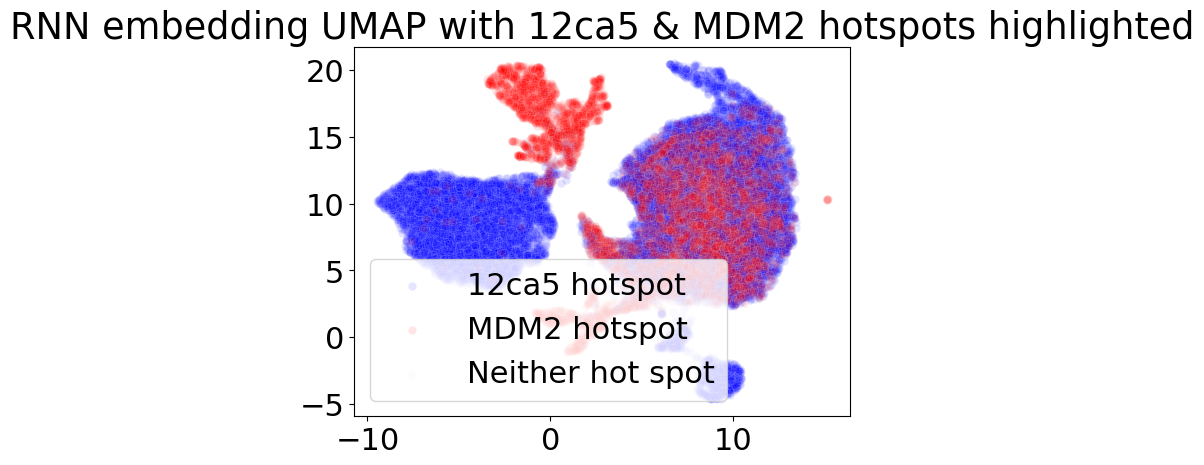

In [13]:
umap.UMAP_dual_vis(embedding, y_raw)

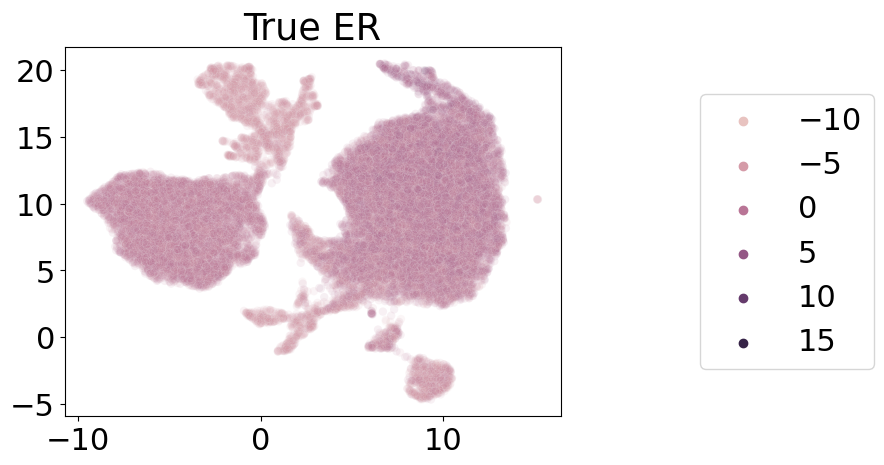

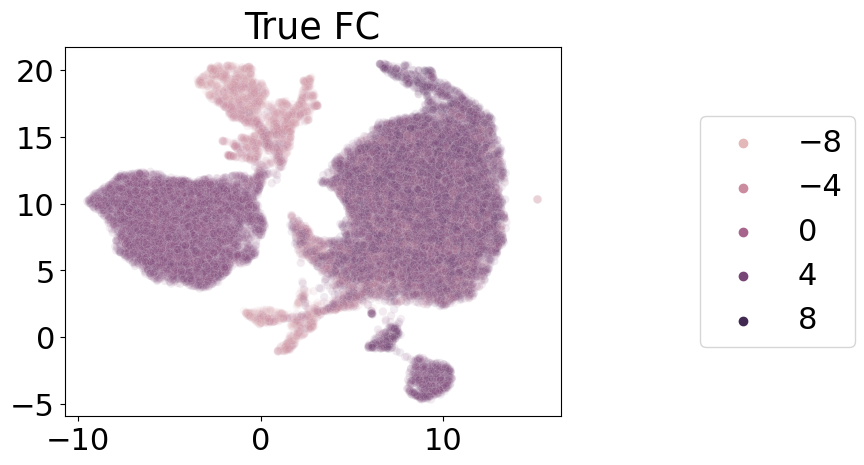

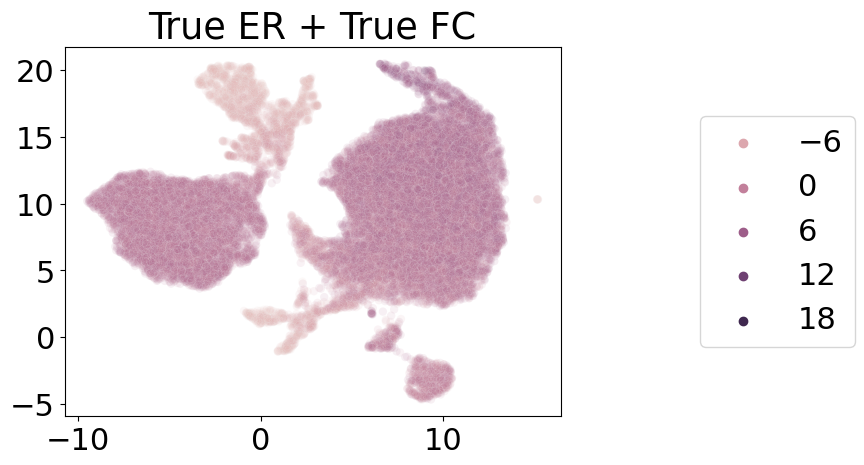

In [14]:
umap.UMAP_vis(embedding, y_raw[:,2], title='True ER')
plt.show()
umap.UMAP_vis(embedding, y_raw[:,1], title='True FC')
plt.show()
umap.UMAP_vis(embedding, y_raw[:,2] + y_pred[:,1], title='True ER + True FC')
plt.show()

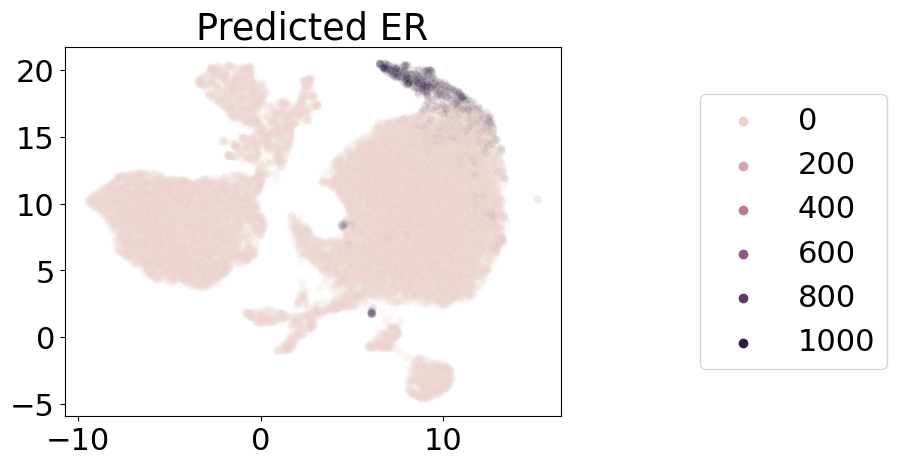

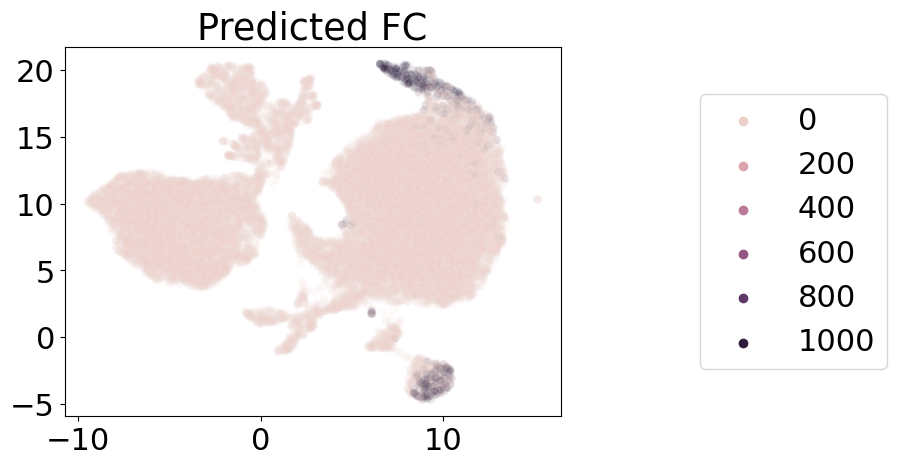

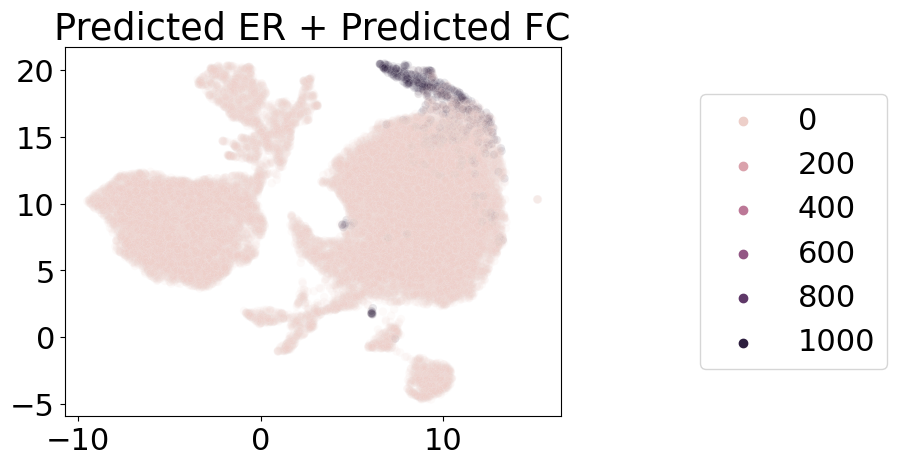

In [15]:
umap.UMAP_vis_top_500(embedding, y_pred[:,2], title='Predicted ER')
umap.UMAP_vis_top_500(embedding, y_pred[:,1], title='Predicted FC')
umap.UMAP_vis_top_500(embedding, y_pred[:,2] + y_pred[:,1], title='Predicted ER + Predicted FC')
